In [2]:
import pandas
import torch
import pickle
import training
import utilities
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import nltk
import sklearn.metrics.pairwise


%matplotlib inline


dataDir = 'data'
modelsDir = 'models'

rawFname = 'Stats-journs.tsv'
manualFname = 'classified.yaml'

w2vFname = 'word2vec.bin'
pickleFname = 'dfPickles.p'
regenW2V = False

eta = 0.001
numEpochs = 50
epochSize = 500

In [64]:
def compareRows(rows, N, useTitle = True, w2v = None):
    fig, axes = plt.subplots(figsize = (20,25),
                             nrows = len(rows) + 1,
                             gridspec_kw = {'height_ratios': [5] * len(rows) + [1]})
    aLst = []
    for i, row in enumerate(rows):
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        out = N(abVec, tiVec)
        probNeg = np.exp(out.data[0][0])
        probPos = np.exp(out.data[0][1])            
        probNeg = probNeg / (probNeg + probPos)
        probPos = probPos / (probNeg + probPos)
        
        a = np.array(outLSTM.data.tolist())
        aLst.append(a[0, -1, :])
        #a = a[:,:100,:]
        df = pandas.DataFrame(a[0, :, :])
        df.index = nltk.word_tokenize(s)[:a.shape[1]]
        seaborn.heatmap(df, ax = axes[i], label='big')
        axes[i].set_title("Article Title: '{}'\n$P_{{negative}} = {:.4f}, P_{{positive}} = {:.4f}$".format(row['title'], probNeg, probPos), fontsize = 20)
        axes[i].set_xticklabels([])
        
    
    dfDiff = pandas.DataFrame(np.stack([aLst[0], np.fabs(aLst[0] - aLst[1]), aLst[1]]))
    dfDiff.index = ['Top', 'Diff', 'Bottom']
    seaborn.heatmap(dfDiff, ax = axes[-1], xticklabels = [i if i in np.linspace(0, len(dfDiff.columns) - 1, num = 10, dtype='int') else '' for i in range(len(dfDiff.columns))])
    axes[-1].set_title('Difference in Final Output Vectors', fontsize = 20)
    
    return fig, axes

In [4]:
def wordDiff(df, N, useTitle = True, w2v = None):
    wDiffs = {}
    for i, (n, row) in enumerate(df.iterrows()):
        print("{:.0f}% Done".format(i / len(df) * 100), end = '\r')
        if 'title_vecs' in row:
            abVec, tiVec, yVec = utilities.varsFromRow(row)
        else:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
        if useTitle:
            outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
            s = row['title']
        else:
            outLSTM, (h_n, c_n) = N.lstmAb(abVec)
            s = row['abstract']
        if not isinstance(s, str):
            continue
        out = N(abVec, tiVec)
        a = np.array(outLSTM.data.tolist())[0]
        diffs = []
        for i in range(a.shape[0]):
            try:
                dU = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i - 1].reshape(1, -1), a[i].reshape(1, -1))
            except IndexError:
                dU = 0
            try:
                dD = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i + 1].reshape(1, -1), a[i].reshape(1, -1))
                if dU == 0:
                    dU = dD
            except IndexError:
                dD = dU
            diffs.append(np.mean([dU,dD]))
            
        for d, w in zip(diffs, nltk.word_tokenize(s.lower())):
            if w in wDiffs:
                wDiffs[w].append(d)
            else:
                wDiffs[w]= [d]
    return {w : np.mean(d) for w, d in wDiffs.items()}

In [5]:
def wordDiffPlot(row, N, useTitle = True, w2v = None):
    fig, ax = plt.subplots(figsize = (10,5))
    if 'title_vecs' in row:
        abVec, tiVec, yVec = utilities.varsFromRow(row)
    else:
        abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
    if useTitle:
        outLSTM, (h_n, c_n) = N.lstmTi(tiVec)
        s = row['title']
    else:
        outLSTM, (h_n, c_n) = N.lstmAb(abVec)
        s = row['abstract']
    out = N(abVec, tiVec)
    a = np.array(outLSTM.data.tolist())[0]
    diffs = []
    for i in range(a.shape[0]):
        try:
            dU = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i - 1].reshape(1, -1), a[i].reshape(1, -1))
        except IndexError:
            dU = 0
        try:
            dD = 1 - sklearn.metrics.pairwise.cosine_similarity(a[i + 1].reshape(1, -1), a[i].reshape(1, -1))
            if dU == 0:
                dU = dD
        except IndexError:
            dD = dU
        diffs.append(np.mean([dU,dD]))
    dfDiffs = pandas.DataFrame({'diff' : diffs})
    #dfDiffs['loc'] = dfDiffs.index
    dfDiffs.index = nltk.word_tokenize(s)
    dfDiffs = dfDiffs#[1:-1]
    dfDiffs.plot(ax = ax)
    print("Done      ")
    return dfDiffs

In [6]:
with open("models/BiRNN-2-256-9.pt", 'rb') as f:
    N = torch.load(f)
N.cuda()

/Users/Reid/anaconda/lib/python3.6/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'neuralnet.BiRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


BiRNN-2-256-9

In [7]:
df, w2v = utilities.preprocesing(dataDir, rawFname, modelsDir, w2vFname, pickleFname)
dfTrain, dfTest = utilities.getTrainTest(df, dataDir, manualFname, w2v)
df.index = df['wos_id']

Loading W2V
Loading DF
Generating training and testing sets
Generating word vectors
Enriching training set


In [8]:
print('There are {} total records'.format(len(df)))

There are 78971 total records


In [9]:
regen = False
if regen:
    catsDict = {
        'title' : [],
        'wos_id' : [],
        'abstract' : [],
        'source' : [],
        'weightP' : [],
        'weightN' : [],
    }

    tDF = df
    for i, row in tDF.iterrows():
        print(i / len(tDF), end = '\r')
        try:
            abVec, tiVec, yVec = utilities.varsFromRow(row, w2v)
            out = N(abVec, tiVec)
        except Exception as e:
            print(e)
            print(row['wos_id'])
            continue
        catsDict['weightN'].append(out.data[0][0])
        catsDict['weightP'].append(out.data[0][1])
        catsDict['title'].append(row['title'])
        catsDict['wos_id'].append(row['wos_id'])
        catsDict['abstract'].append(row['abstract'])
        catsDict['source'].append(row['source'])
    dfY = pandas.DataFrame(catsDict)
else:
    dfY = pandas.read_csv('outputs/withYears.csv', index_col='wos_id')
dfY = dfY.drop(float('nan'))
dfY['isSoftware'] = dfY['weightP'] > dfY['weightN']
dfY['New software'] = dfY['isSoftware']

In [10]:
dfYearCounts = dfY.groupby(['New software', 'pubyear'])['pubyear'].count()
dfYearCounts = pandas.DataFrame({'True' : dfYearCounts.loc[True], 'False' : dfYearCounts.loc[False],'tot' : df.groupby(['pubyear'])['pubyear'].count()})
dfYearCounts['ratio'] = dfYearCounts['True'] / dfYearCounts['tot']
dfYearCounts[['tot', 'False', 'True', 'ratio']]

,tot,False,True,ratio
pubyear,,,,
2005,5235,4998,237,0.045272
2006,5806,5522,284,0.048915
2007,6255,5914,341,0.054516
2008,7085,6703,382,0.053917
2009,7435,7047,388,0.052186
2010,7216,6800,415,0.057511
2011,7767,7280,487,0.062701
2012,7990,7519,471,0.058949
2013,8287,7829,458,0.055267


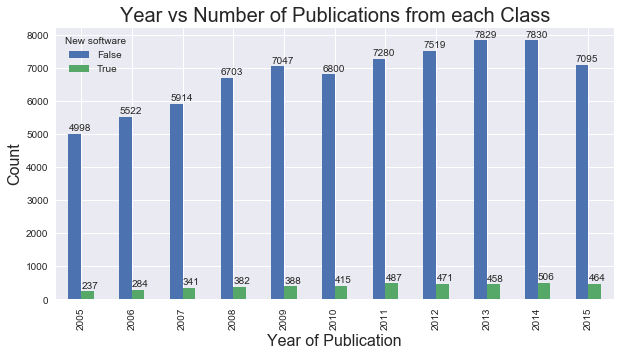

In [11]:
fig, ax = plt.subplots(figsize = (10, 5))
x_offset = -0.12

dfPlt = dfY.groupby(['New software', 'pubyear'])['pubyear'].count().unstack('New software')
dfPlt.plot(kind='bar', ax = ax)#, stacked=True)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Year of Publication', fontsize=16)
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 +100))
ax.set_title('Year vs Number of Publications from each Class', fontsize=20)
#plt.savefig('images/countvyear.pdf', format='pdf')
plt.show()

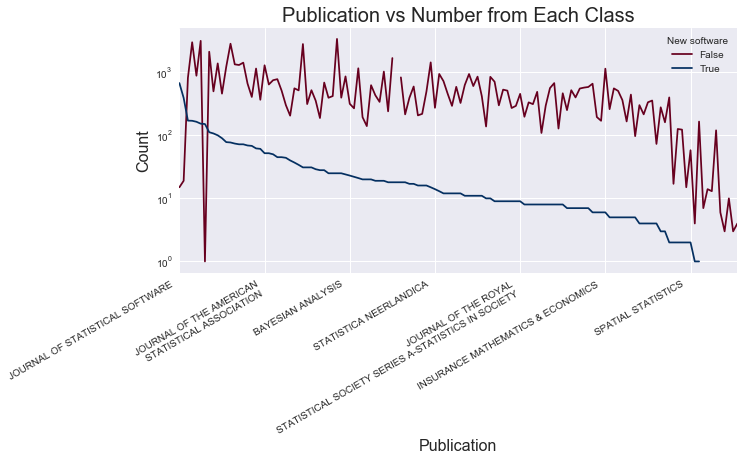

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))

df2 = dfY.groupby(['New software', 'source'])['source'].count().unstack('New software')
df2 = df2#[df2[True] > 0]
df2.index = ["{}\n{}".format(' '.join(s.split(' ')[:4]), ' '.join(s.split(' ')[4:])) for s in df2.index]
df2.sort_values(by=True,ascending=False).plot(kind='line', ax = ax, colormap= "RdBu")
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Publication', fontsize=16)
#ax.xticks = [s if i % 2 ==0 else '' for i, s in enumerate(df2.index)]
ax.set_title('Publication vs Number from Each Class', fontsize=20)
#plt.savefig('images/countvyear.pdf', format='pdf')
fig.autofmt_xdate()
ax.semilogy()
plt.savefig('images/countvpub.pdf', format='pdf', transparent = False)

plt.show()

In [13]:
tJ = [
    'STATISTICAL METHODS IN MEDICAL RESEARCH',
    'JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY',
    'ECONOMETRICA',
    'BRITISH JOURNAL OF MATHEMATICAL & STATISTICAL PSYCHOLOGY',
    'ANNUAL REVIEW OF STATISTICS AND ITS APPLICATION',
    'ANNALS OF STATISTICS',
    'STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASSESSMENT',
    'TECHNOMETRICS',
]
dfSourceCounts = dfY.groupby(['isSoftware', 'source']).size()
dfSourceCounts.loc[False].sort_values(ascending=False)[tJ]#.plot()

source
STATISTICAL METHODS IN MEDICAL RESEARCH                                       354.0
JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY     393.0
ECONOMETRICA                                                                  627.0
BRITISH JOURNAL OF MATHEMATICAL & STATISTICAL PSYCHOLOGY                      268.0
ANNUAL REVIEW OF STATISTICS AND ITS APPLICATION                                 NaN
ANNALS OF STATISTICS                                                         1156.0
STOCHASTIC ENVIRONMENTAL RESEARCH AND RISK ASSESSMENT                        1025.0
TECHNOMETRICS                                                                 395.0
dtype: float64

In [14]:
r1 = df.loc['WOS:000272110900028']
r2 = df.loc['WOS:000280216700014']

In [39]:
dfY[dfY['isSoftware'] == False]

,Unnamed: 0,title,weightP,weightN,source,abstract,pubyear,isSoftware,New software
wos_id,,,,,,,,,
WOS:000202958400001,WOS:000202958400001,Low-order conditional independence graphs for ...,-2.860818,2.981237,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,As a powerful tool for analyzing full conditio...,2006,False,False
WOS:000202958400002,WOS:000202958400002,"A generalized clustering problem, with applica...",-2.673335,2.809064,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,We think of cluster analysis as class discover...,2006,False,False
WOS:000202958400003,WOS:000202958400003,A Bayes regression approach to array-CGH data,-3.081291,3.197178,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,This paper develops a Bayes regression model h...,2006,False,False
WOS:000202958400004,WOS:000202958400004,Statistical selection of maintenance genes for...,-2.925542,3.121233,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Maintenance genes can be used for normalizatio...,2006,False,False
WOS:000202958400005,WOS:000202958400005,Predicting the strongest domain-domain contact...,-2.851388,2.988621,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Experiments to determine the complete 3- dimen...,2006,False,False
WOS:000202958400006,WOS:000202958400006,Dimension reduction for classification with ge...,-2.896404,3.028564,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,An important application of gene expression mi...,2006,False,False
WOS:000202958400007,WOS:000202958400007,A new type of stochastic dependence revealed i...,-3.531389,3.699627,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Modern methods of microarray data analysis are...,2006,False,False
WOS:000202958400008,WOS:000202958400008,A new order estimator for fixed and variable l...,-2.831211,3.108072,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Recently Peres and Shields discovered a new me...,2006,False,False
WOS:000202958400009,WOS:000202958400009,Treating expression levels of different genes ...,-2.218991,2.446812,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,One of the prevailing ideas in the literature ...,2006,False,False


In [50]:

r1 = df.loc['WOS:000365978900001']
r2 = df.loc['WOS:000207446800001']

In [51]:
#row = df.loc['WOS:000272110900028']
print("r1")
print(r1['title'])
print()
print(r1['abstract'])
print(r1['pubyear'])
print("\nr2")
print(r2['title'])
print()
print(r2['abstract'])
print(r2['pubyear'])

r1
dawai: An R Package for Discriminant Analysis with Additional Information

The incorporation of additional information into discriminant rules is receiving increasing attention as the rules including this information perform better than the usual rules. In this paper we introduce an R package called dawai, which provides the functions that allow to define the rules that take into account this additional information expressed in terms of restrictions on the means, to classify the samples and to evaluate the accuracy of the results. Moreover, in this paper we extend the results and definitions given in previous papers (Fernandez, Rueda, and Salvador 2006, Conde, Fernandez, Rueda, and Salvador 2012, Conde, Salvador, Rueda, and Fernandez 2013) to the case of unequal co-variances among the populations, and consequently define the corresponding restricted quadratic discriminant rules. We also define estimators of the accuracy of the rules for the general more than two populations case. Th

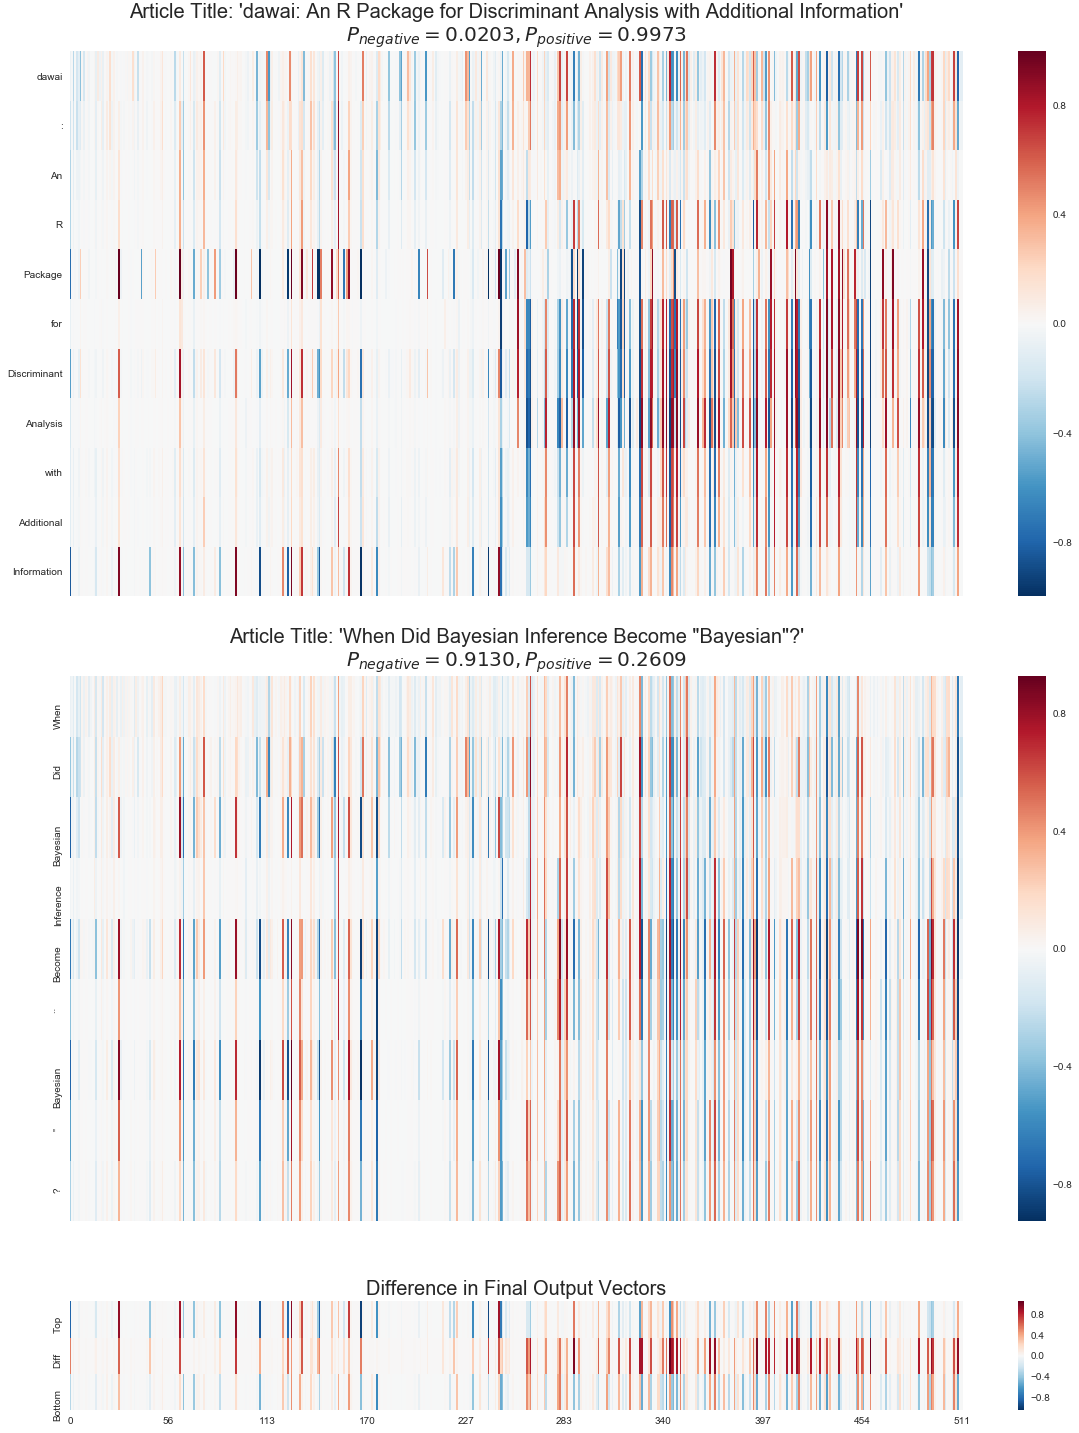

In [65]:
compareRows([r1, r2],N, w2v = w2v)
plt.savefig('images/comparisonTitle.pdf', format  = 'pdf', transparent=True)
plt.show()

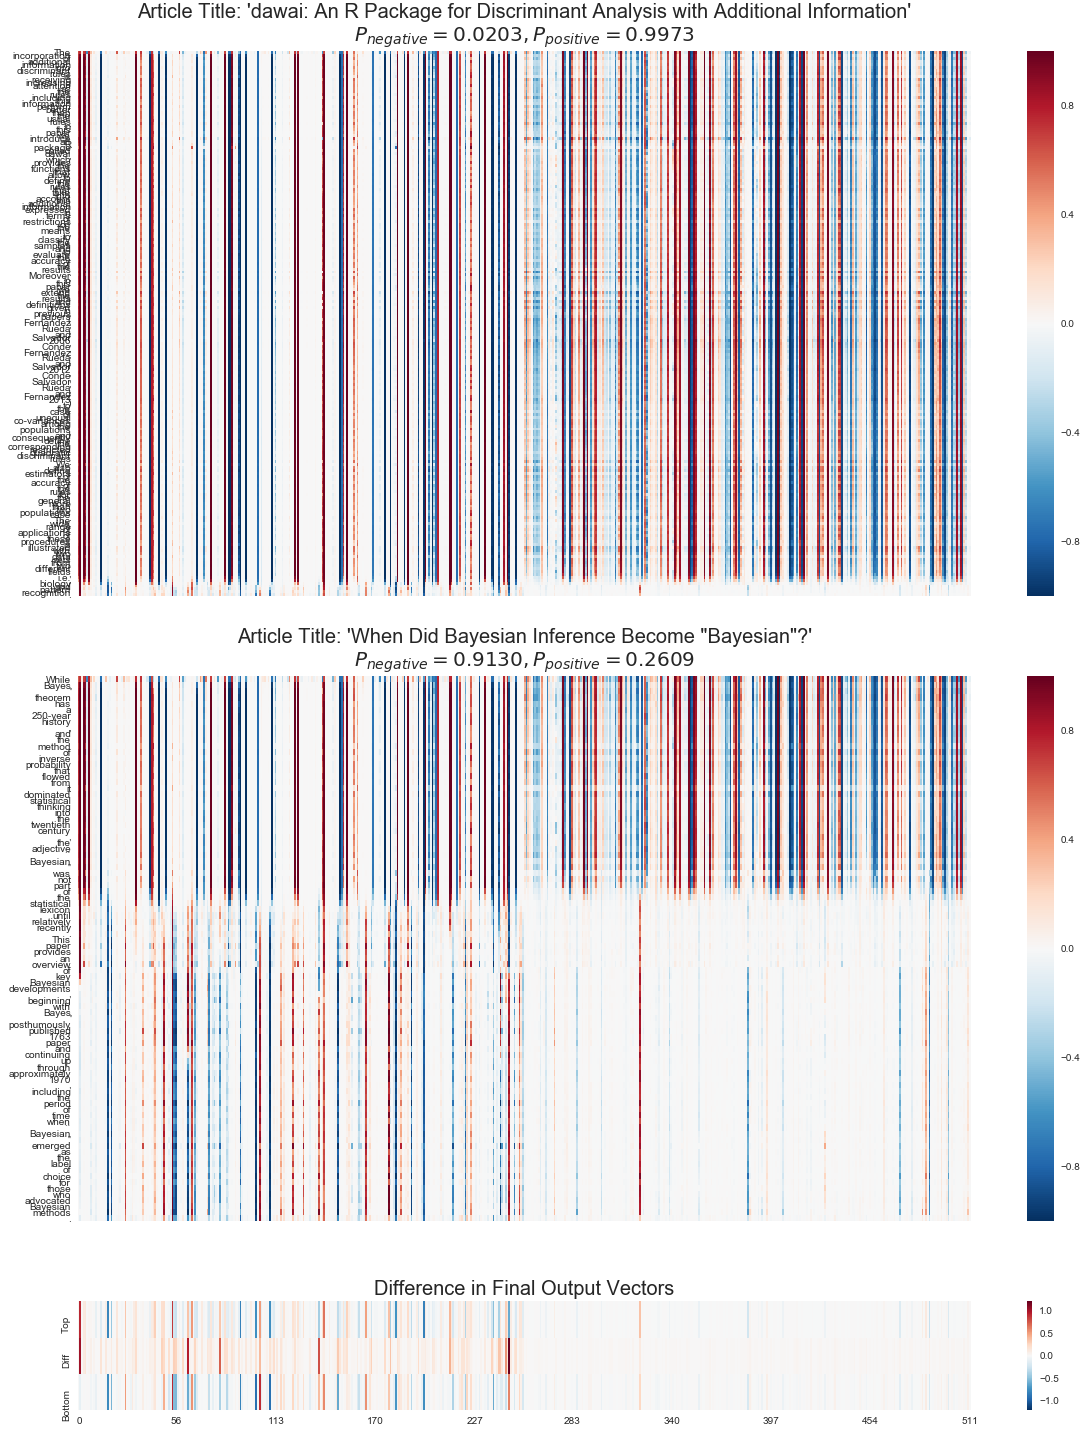

In [66]:
compareRows([r1, r2],N, useTitle=False, w2v = w2v)
plt.savefig('images/comparisonAbstract.pdf', format  = 'pdf', transparent=True)
plt.show()

In [ ]:
dfDiffs= wordDiffPlot(r1, N, useTitle = False, w2v = w2v)
plt.show()
dfDiffs= wordDiffPlot(r2, N, useTitle = False, w2v = w2v)
plt.show()

In [67]:
langs = ['c', 'c++', 'python', 'stata', 'matlab', 'r', 'java', 'mathematica', 'sas', 'spss', 'javascript', 'perl']

In [68]:
idsPython = [w for w, a, t in zip(dfY.index, dfY['abstract'], dfY['title']) if 'python' in (t + ' ' + a).lower()]

In [69]:
df

,id,wos_id,accession_no,issn,issn_int,eissn,isbn,eisbn,art_no,doi,...,pubday,language,source,page_range,page_count,has_abstract,wos_id.1,abstract,title_tokens,abstract_tokens
wos_id,,,,,,,,,,,,,,,,,,,,,
WOS:000279486900009,743,WOS:000279486900009,620GK,0932-5026,932502.0,NaN,NaN,NaN,NaN,10.1007/s00362-008-0172-x,...,1,English,STATISTICAL PAPERS,325-336,12,1,WOS:000279486900009,Marshall-Olkin extended distributions offer a ...,"[testing, for, the, marshall-olkin, extended, ...","[[marshall-olkin, extended, distributions, off..."
WOS:000279657800014,2190,WOS:000279657800014,622JG,0167-9473,167947.0,1872-7352,NaN,NaN,NaN,10.1016/j.csda.2009.10.001,...,1,English,COMPUTATIONAL STATISTICS & DATA ANALYSIS,2532-2553,22,1,WOS:000279657800014,Simple point-optimal sign-based tests are deve...,"[exact, optimal, inference, in, regression, mo...","[[simple, point-optimal, sign-based, tests, ar..."
WOS:000283791000003,2191,WOS:000283791000003,674ZC,1050-5164,1050516.0,NaN,NaN,NaN,NaN,10.1214/09-AAP632,...,1,English,ANNALS OF APPLIED PROBABILITY,1638-1662,25,1,WOS:000283791000003,"In this paper, the forgetting of the initial d...","[forgetting, of, the, initial, distribution, f...","[[in, this, paper, ,, the, forgetting, of, the..."
WOS:000276085800003,2489,WOS:000276085800003,575RQ,0167-9473,167947.0,NaN,NaN,NaN,NaN,10.1016/j.csda.2009.12.008,...,1,English,COMPUTATIONAL STATISTICS & DATA ANALYSIS,1219-1233,15,1,WOS:000276085800003,The problem of curve clustering when curves ar...,"[k-mean, alignment, for, curve, clustering]","[[the, problem, of, curve, clustering, when, c..."
WOS:000280128700013,2688,WOS:000280128700013,628OB,0894-9840,894984.0,1572-9230,NaN,NaN,NaN,10.1007/s10959-010-0282-y,...,1,English,JOURNAL OF THEORETICAL PROBABILITY,920-943,24,1,WOS:000280128700013,To a given finite graph we associate three kin...,"[reinforced, random, walks, and, adic, transfo...","[[to, a, given, finite, graph, we, associate, ..."
WOS:000283528500024,2772,WOS:000283528500024,671RW,1932-6157,1932615.0,NaN,NaN,NaN,NaN,10.1214/09-AOAS302,...,1,English,ANNALS OF APPLIED STATISTICS,1056-1080,25,1,WOS:000283528500024,In generalized linear regression problems with...,"[feature, selection, guided, by, structural, i...","[[in, generalized, linear, regression, problem..."
WOS:000281779200001,2942,WOS:000281779200001,649NT,1544-6115,1544611.0,NaN,NaN,NaN,ARTN 29,10.2202/1544-6115.1434,...,1,English,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,NaN,31,1,WOS:000281779200001,High density tiling arrays are an effective st...,"[generalizing, moving, averages, for, tiling, ...","[[high, density, tiling, arrays, are, an, effe..."
WOS:000278928800009,3021,WOS:000278928800009,612UH,0964-1998,964199.0,NaN,NaN,NaN,NaN,NaN,...,1,English,JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIE...,631-656,26,1,WOS:000278928800009,P>The paper analyses longitudinal Compustat da...,"[an, econometric, analysis, of, dividends, and...","[[p, >, the, paper, analyses, longitudinal, co..."
WOS:000271548500005,3209,WOS:000271548500005,516NF,0026-1335,26133.0,NaN,NaN,NaN,NaN,10.1007/s00184-008-0202-7,...,1,English,METRIKA,59-77,19,1,WOS:000271548500005,A typical microarray experiment often involves...,"[a, generalized, correlated, binomial, distrib...","[[a, typical, microarray, experiment, often, i..."


In [84]:
langCounts = {}
for j, (i, row) in enumerate(df.iterrows()):
    print(j, end = '\r')
    tokens = row['abstract_tokens'] + row['title_tokens']
    try:
        if dfY.loc[i]['isSoftware']:
            for l in langs:
                if l in tokens:
                    try:
                        langCounts[l].append(i)
                    except KeyError:
                        langCounts[l] = [i]
    except KeyError:
        pass

In [71]:
dfC = dfY.loc[langCounts['c']]

In [72]:
index = []
count = []
for k, v in langCounts.items():
    index.append(k)
    count.append(len(v))

In [82]:
dfL = pandas.DataFrame({'count' : count}, index = [i.title() for i in index]).sort_values('count', ascending=False)

In [83]:
print(dfL.to_latex())

\begin{tabular}{lr}
\toprule
{} &  count \\
\midrule
R           &    566 \\
Stata       &    130 \\
Matlab      &     37 \\
Sas         &     32 \\
C           &     12 \\
Mathematica &      7 \\
Python      &      6 \\
Java        &      3 \\
Spss        &      1 \\
C++         &      1 \\
\bottomrule
\end{tabular}



In [26]:
texNames = [
    ('Unnamed: 0', 'ID'),
    ('source' , 'Source'),
    ('pubyear' , 'Year of Publications'),
    ('title' , 'Title'),
    ('abstract' , 'Abstract'),
    ]

def rowToTex(row, cutoff = 70):
    print(r"""\begin{figure}[H]
	\begin{tabular}{ll}
		\toprule
		Field & Value\\
		\midrule""")
    for rN, tN in texNames:
        if len(str(row[rN])) < cutoff:
            print('\t\t{} & {} \\\\'.format(tN, row[rN]))
        else:
            s = str(row[rN])
            ts = s.split(' ')
            sOut = ['']
            while len(ts) > 0:
                subT = ts.pop(0)
                if len(sOut[-1] + ' ' + subT) < cutoff:
                    sOut[-1] += ' ' + subT
                else:
                    sOut.append(subT)
            print('\t\t{} & {} \\\\'.format(tN, '\\\\\n\t\t&'.join(sOut)))
    print(r"""		\bottomrule
	\end{tabular}
\end{figure}""")

In [28]:
len(w2v.wv.vocab)


134420

In [29]:
rExample = dfY.loc['WOS:000341806800001']
rowToTex(rExample)

\begin{figure}[H]
	\begin{tabular}{ll}
		\toprule
		Field & Value\\
		\midrule
		ID & WOS:000341806800001 \\
		Source & JOURNAL OF STATISTICAL SOFTWARE \\
		Year of Publications & 2014 \\
		Title & Tidy Data \\
		Abstract &  A huge amount of effort is spent cleaning data to get it ready for\\
		&analysis, but there has been little research on how to make data\\
		&cleaning as easy and effective as possible. This paper tackles a\\
		&small, but important, component of data cleaning: data tidying. Tidy\\
		&datasets are easy to manipulate, model and visualize, and have a\\
		&specific structure: each variable is a column, each observation is a\\
		&row, and each type of observational unit is a table. This framework\\
		&makes it easy to tidy messy datasets because only a small set of\\
		&tools are needed to deal with a wide range of un-tidy datasets. This\\
		&structure also makes it easier to develop tidy tools for data\\
		&analysis, tools that both input and output tidy datasets. The

In [ ]:
reversed

In [60]:
{k : len(v) for k, v in langCounts.items()}

{'c': 12,
 'c++': 1,
 'java': 3,
 'mathematica': 7,
 'matlab': 37,
 'python': 6,
 'r': 566,
 'sas': 32,
 'spss': 1,
 'stata': 130}

In [76]:
dfY[dfY['source'] == 'JOURNAL OF STATISTICAL SOFTWARE'][dfY['isSoftware'] == False]

/Users/Reid/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Unnamed: 0,title,weightP,weightN,source,abstract,pubyear,isSoftware,New software
wos_id,,,,,,,,,
WOS:000232806900001,WOS:000232806900001,A comment on the implementation of the Ziggura...,-0.329924,0.544691,JOURNAL OF STATISTICAL SOFTWARE,We show that the short period of the uniform r...,2005,False,False
WOS:000232928700001,WOS:000232928700001,Monkeying with the goodness-of-fit test,-1.689415,1.836649,JOURNAL OF STATISTICAL SOFTWARE,The familiar Sigma(OBS - EXP)(2)/EXP goodness-...,2005,False,False
WOS:000239139800001,WOS:000239139800001,SAS/IML macros for a multivariate analysis of ...,-2.356973,2.514093,JOURNAL OF STATISTICAL SOFTWARE,"Recently, new nonparametric multivariate exten...",2006,False,False
WOS:000244068200001,WOS:000244068200001,ImpuR: A collection of diagnostic tools develo...,-2.393017,2.572254,JOURNAL OF STATISTICAL SOFTWARE,HPLC-DAD systems generate time intensity ( abs...,2007,False,False
WOS:000247010700001,WOS:000247010700001,Estimating the multilevel Rasch model: with th...,-2.849601,3.103151,JOURNAL OF STATISTICAL SOFTWARE,Traditional Rasch estimation of the item and s...,2007,False,False
WOS:000247011300001,WOS:000247011300001,Multilevel IRT modeling in practice with the p...,-3.489167,3.648045,JOURNAL OF STATISTICAL SOFTWARE,Variance component models are generally accept...,2007,False,False
WOS:000266310500001,WOS:000266310500001,SOCR Analyses: Implementation and Demonstratio...,-0.875291,1.065865,JOURNAL OF STATISTICAL SOFTWARE,"The web-based, Java-written SOCR (Statistical ...",2009,False,False
WOS:000281587700001,WOS:000281587700001,Controlled Optimal Design Program for the Logi...,-0.914292,1.048440,JOURNAL OF STATISTICAL SOFTWARE,The assessment of dose-response is an integral...,2010,False,False
WOS:000281593300001,WOS:000281593300001,On Simulation of Manifold Indexed Fractional G...,-0.640027,0.704079,JOURNAL OF STATISTICAL SOFTWARE,To simulate fractional Brownian motion indexed...,2010,False,False


In [41]:
dfY.loc['WOS:000292681800006']['title']

'Designing Logical Rules to Model the Response of Biomolecular Networks with Complex Interactions: An Application to Cancer Modeling'

In [23]:
wD = wordDiff(df[:100], N, useTitle = False, w2v = w2v)
indices = []
vals = []
for k, v in wD.items():
    indices.append(k)
    vals.append(v)

dfDiffs = pandas.DataFrame({'diff' : vals})
dfDiffs.index = indices
dfDiffs.sort_values('diff',ascending=False)

,diff
outcome-dependent,0.508437
doubly,0.494429
continuous-time,0.426054
implementation,0.322160
2008,0.316634
freely,0.294390
marshall-olkin,0.285278
b.v.,0.281162
elsevier,0.266231
&,0.262592


In [122]:
dfY

,Unnamed: 0,title,weightP,weightN,source,abstract,pubyear,isSoftware,New software
wos_id,,,,,,,,,
WOS:000202958400001,WOS:000202958400001,Low-order conditional independence graphs for ...,-2.860818,2.981237,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,As a powerful tool for analyzing full conditio...,2006,False,False
WOS:000202958400002,WOS:000202958400002,"A generalized clustering problem, with applica...",-2.673335,2.809064,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,We think of cluster analysis as class discover...,2006,False,False
WOS:000202958400003,WOS:000202958400003,A Bayes regression approach to array-CGH data,-3.081291,3.197178,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,This paper develops a Bayes regression model h...,2006,False,False
WOS:000202958400004,WOS:000202958400004,Statistical selection of maintenance genes for...,-2.925542,3.121233,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Maintenance genes can be used for normalizatio...,2006,False,False
WOS:000202958400005,WOS:000202958400005,Predicting the strongest domain-domain contact...,-2.851388,2.988621,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Experiments to determine the complete 3- dimen...,2006,False,False
WOS:000202958400006,WOS:000202958400006,Dimension reduction for classification with ge...,-2.896404,3.028564,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,An important application of gene expression mi...,2006,False,False
WOS:000202958400007,WOS:000202958400007,A new type of stochastic dependence revealed i...,-3.531389,3.699627,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Modern methods of microarray data analysis are...,2006,False,False
WOS:000202958400008,WOS:000202958400008,A new order estimator for fixed and variable l...,-2.831211,3.108072,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,Recently Peres and Shields discovered a new me...,2006,False,False
WOS:000202958400009,WOS:000202958400009,Treating expression levels of different genes ...,-2.218991,2.446812,STATISTICAL APPLICATIONS IN GENETICS AND MOLEC...,One of the prevailing ideas in the literature ...,2006,False,False


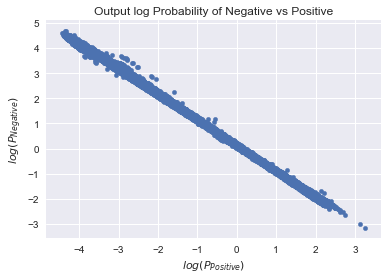

In [135]:
fig, ax = plt.subplots()
dfY.plot.scatter('weightP', 'weightN', ax = ax)
ax.set_ylabel('$log(P_{Negative})$')
ax.set_xlabel('$log(P_{Positive})$')
ax.set_title('Output log Probability of Negative vs Positive')
plt.savefig('images/weight.pdf', format = 'pdf')
plt.show()